In [1]:
import geopandas as gpd
import pandas as pd
import networkx as nx
import osmnx as ox
from shapely.geometry import Point
from tqdm import tqdm
import numpy as np
from shapely.geometry import LineString

In [2]:
print(ox.__version__)

2.0.1


In [3]:
# G = ox.load_graphml("output/G_combined_final.graphml")

In [4]:
# G = ox.project_graph(G, to_crs="EPSG:27700")

In [5]:
G = ox.load_graphml("output/inner_london_walk.graphml")

In [6]:
G = ox.project_graph(G, to_crs="EPSG:27700")

In [7]:
G_undirected = nx.Graph()

for u, v, data in G.edges(data=True):
    if G_undirected.has_edge(u, v):
        continue
    if "length" not in data:
        x1, y1 = G.nodes[u]["x"], G.nodes[u]["y"]
        x2, y2 = G.nodes[v]["x"], G.nodes[v]["y"]
        geom = LineString([(x1, y1), (x2, y2)])
        data["length"] = geom.length
        data["geometry"] = geom
    G_undirected.add_edge(u, v, **data)

for node, data in G.nodes(data=True):
    G_undirected.add_node(node, **data)

G_undirected.graph['crs'] = "EPSG:27700"

In [8]:
print(G_undirected.graph.get("crs"))

EPSG:27700


In [9]:
list(G_undirected.nodes(data=True))[0]

(78112, {'y': 182524.98820025317, 'x': 528723.2526330745, 'street_count': 3})

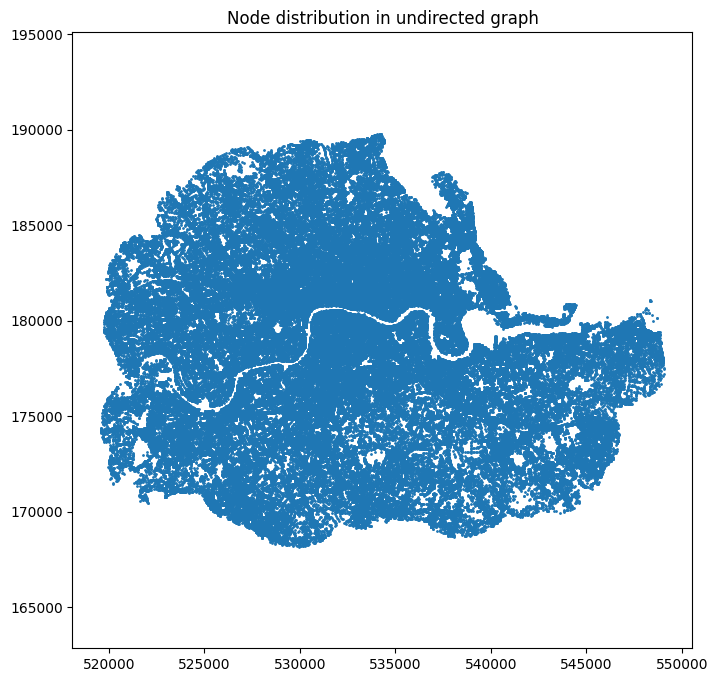

In [10]:
import matplotlib.pyplot as plt

x = [data["x"] for _, data in G_undirected.nodes(data=True)]
y = [data["y"] for _, data in G_undirected.nodes(data=True)]

plt.figure(figsize=(8, 8))
plt.scatter(x, y, s=1)
plt.title("Node distribution in undirected graph")
plt.axis("equal")
plt.show()

In [11]:
print("nodes：", G_undirected.number_of_nodes())
print("edges：", G_undirected.number_of_edges())

nodes： 210030
edges： 270675


In [12]:
import networkx as nx

if nx.is_connected(G_undirected):
    print("✅ The graph is connected")
else:
    print("❗The graph is not connected, contains isolated subgraphs")
    # You can also choose to keep only the largest connected component
    G_undirected = G_undirected.subgraph(max(nx.connected_components(G_undirected), key=len)).copy()
    print("Kept the largest subgraph, number of nodes:", G_undirected.number_of_nodes())

✅ The graph is connected


In [13]:
import networkx as nx
import pandas as pd
import numpy as np
import osmnx as ox
import pyproj
from shapely.geometry import Point, LineString
from shapely.ops import transform
import copy
from tqdm import tqdm
from itertools import islice

# Insert this before the function definition or above insert_point_into_graph()
def get_edges_gdf_from_graph(G):
    """
    Extract edges from Graph or DiGraph, compatible with non-MultiGraph, without using keys.
    """
    edge_data = []
    for u, v, data in G.edges(data=True):
        if "geometry" in data:
            edge_data.append({
                "u": u,
                "v": v,
                "geometry": data["geometry"],
                "length": data.get("length", data["geometry"].length)
            })
    return gpd.GeoDataFrame(edge_data, crs="EPSG:27700")


def insert_point_into_graph(G, point_proj, node_id, edges_gdf=None):
    """
    Insert a real-world point onto its nearest edge, create a pseudo-node, and split the edge.

    Parameters:
    - G: networkx.Graph (EPSG:27700, simple graph without multi-edges)
    - point_proj: shapely.geometry.Point (already projected)
    - node_id: ID of the newly inserted node (e.g., "source_001")
    - edges_gdf: optional, GeoDataFrame of edges corresponding to G (with u,v,geometry)

    Returns:
    - G_new: modified graph
    - node_id: the newly inserted node ID (for path planning)
    """
    if edges_gdf is None:
        edges_gdf = get_edges_gdf_from_graph(G).reset_index(drop=True)

    # Find the nearest edge to the point
    edges_gdf["distance"] = edges_gdf["geometry"].distance(point_proj)
    nearest_edge = edges_gdf.loc[edges_gdf["distance"].idxmin()]
    u, v = nearest_edge["u"], nearest_edge["v"]
    geom = nearest_edge["geometry"]

    # Project the point onto the edge (geometry interpolation)
    projected_point = geom.interpolate(geom.project(point_proj))

    # Create a new graph to keep the original unchanged
    G_new = copy.deepcopy(G)

    # Add the new node
    G_new.add_node(node_id, x=projected_point.x, y=projected_point.y)

    # Remove the original edge
    if G_new.has_edge(u, v):
        G_new.remove_edge(u, v)

    # Insert two new edges (using LineString)
    G_new.add_edge(
        u, node_id,
        length=geom.project(point_proj),
        geometry=LineString([
            (G_new.nodes[u]["x"], G_new.nodes[u]["y"]),
            (projected_point.x, projected_point.y)
        ])
    )

    G_new.add_edge(
        node_id, v,
        length=geom.length - geom.project(point_proj),
        geometry=LineString([
            (projected_point.x, projected_point.y),
            (G_new.nodes[v]["x"], G_new.nodes[v]["y"])
        ])
    )

    return G_new, node_id


In [14]:
# gdf_samples = gpd.read_file("output/gdf_samples_with_edge.gpkg", layer="gvi_points")

In [15]:
# gdf_samples.head(2)

In [16]:
from shapely.geometry import Point
import pyproj
from shapely.ops import transform

# 1. Convert longitude/latitude → EPSG:27700 projection
transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:27700", always_xy=True).transform
source_point = transform(transformer, Point(-0.1191940, 51.5295075))   # Start point: residence
target_point = transform(transformer, Point(-0.1280882, 51.5235315))   # End point: school


In [17]:
# 2. Insert pseudo-nodes
G1, source_node = insert_point_into_graph(G_undirected, source_point, "source_school")
G2, target_node = insert_point_into_graph(G1, target_point, "target_school")


In [18]:
print("Number of nodes:", G2.number_of_nodes())
print("Number of edges:", G2.number_of_edges())
print(G2.nodes["source_school"])
print(G2.nodes["target_school"])

Number of nodes: 210032
Number of edges: 270677
{'x': 530560.2555827597, 'y': 182853.2049103849}
{'x': 529965.7712278819, 'y': 182176.5184620042}


In [19]:
print("Edges of source_school:", list(G2.edges("source_school")))
print("Edges of target_school:", list(G2.edges("target_school")))

Edges of source_school: [('source_school', 18674818), ('source_school', 1158851298)]
Edges of target_school: [('target_school', 6100203537), ('target_school', 11650666780)]


In [20]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import osmnx as ox

# Read CSV and exclude invalid points
df = pd.read_csv("output/GVI_london.csv")
df = df[df["exists"] == 1].copy()

# Convert to GeoDataFrame and set CRS
geometry = [Point(xy) for xy in zip(df["lon"], df["lat"])]
gdf_raw = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
gdf_raw = gdf_raw.to_crs(epsg=27700)

# Read edge table from G2 and set the same CRS
edges_gdf = get_edges_gdf_from_graph(G2)
edges_gdf = edges_gdf.to_crs(epsg=27700)

# Spatially match to the nearest edge and get u, v
gdf_samples = gpd.sjoin_nearest(gdf_raw, edges_gdf, how="left", distance_col="dist")
gdf_samples["edge_id"] = list(zip(gdf_samples["u"], gdf_samples["v"]))

# Save as GPKG for use in path functions
gdf_samples.to_file("output/gdf_samples_with_edge_v2.gpkg", layer="gvi_points", driver="GPKG")



In [21]:
gdf_samples.head()

filename     heading  green_1  green_2  green_3  green_4  green_5  \
0  00000000.jpg  179.072357   0.2388   0.1948   0.1777   0.4290   0.3603   
1  00000001.jpg  179.187866   0.1191   0.1411   0.2282   0.3345   0.3671   
2  00000002.jpg  180.951553   0.2026   0.1007   0.2222   0.1655   0.2515   
3  00000003.jpg  359.003326   0.3606   0.3795   0.2919   0.0513   0.0433   
4  00000004.jpg  343.963409   0.4199   0.3585   0.3560   0.7310   0.6021   

   green_6  green_mean       lon        lat  exists  \
0   0.2963     0.28283 -0.145792  51.526976       1   
1   0.2909     0.24680 -0.145783  51.526802       1   
2   0.1471     0.18159 -0.145805  51.527549       1   
3   0.1769     0.21727 -0.145512  51.527267       1   
4   0.5527     0.50337 -0.152816  51.524364       1   

                        geometry  index_right            u            v  \
0  POINT (528723.253 182524.988)          689  12416627714  12416627711   
1  POINT (528724.368 182505.622)          689  12416627714  12416627711   
2  POINT (528720.792 182588.641)            0     25508584   4595403137   
3  POINT (528741.878 182557.827)          689  12416627714  12416627711   
4  POINT (528243.364 182222.231)            5        99884  12069806659   

       length       dist                     edge_id  
0  191.933889  25.696260  (12416627714, 12416627711)  
1  191.933889  25.403343  (12416627714, 12416627711)  
2   14.696415   0.000000      (25508584, 4595403137)  
3  191.933889   5.694725  (12416627714, 12416627711)  
4   12.955376   0.000000        (99884, 12069806659)

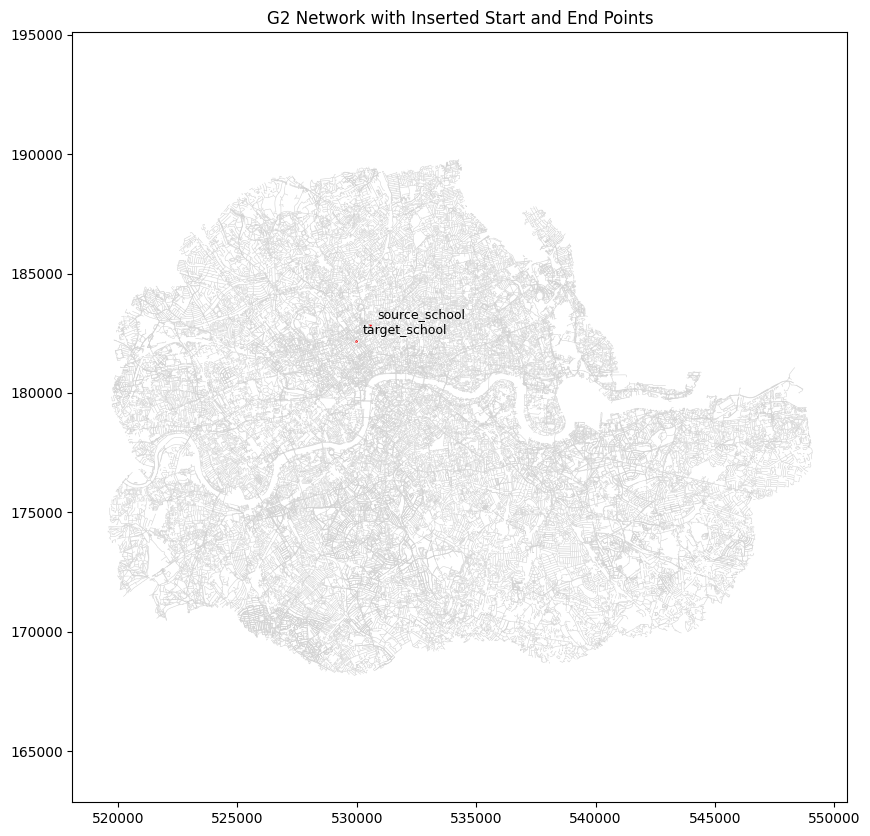

In [22]:
edges_gdf_g2 = get_edges_gdf_from_graph(G2)
from shapely.geometry import Point
import geopandas as gpd

# Get coordinates of pseudo-nodes
node_geoms = [
    Point(G2.nodes["source_school"]["x"], G2.nodes["source_school"]["y"]),
    Point(G2.nodes["target_school"]["x"], G2.nodes["target_school"]["y"])
]
gdf_nodes = gpd.GeoDataFrame(
    {"id": ["source_school", "target_school"]},
    geometry=node_geoms,
    crs="EPSG:27700"
)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
edges_gdf_g2.plot(ax=ax, linewidth=0.4, color="lightgray")
gdf_nodes.plot(ax=ax, color="red", markersize=1)

for idx, row in gdf_nodes.iterrows():
    ax.annotate(row["id"], (row.geometry.x, row.geometry.y), fontsize=9, color="black", xytext=(5, 5), textcoords="offset points")

plt.title("G2 Network with Inserted Start and End Points")
plt.axis("equal")
plt.show()


In [23]:
length_values = [data.get("length") for u, v, data in G2.edges(data=True)]
print("Total number of edges:", len(length_values))
print("Number of edges missing 'length':", sum(pd.isna(length_values)))

Total number of edges: 270677
Number of edges missing 'length': 0


In [24]:
import networkx as nx
import numpy as np
import pandas as pd
from itertools import islice
from tqdm.notebook import tqdm  
from concurrent.futures import ThreadPoolExecutor, as_completed
from networkx.algorithms.simple_paths import shortest_simple_paths

In [25]:
from IPython.display import display
from tqdm.notebook import tqdm
tqdm.pandas()

In [26]:
edge_sample_dict = {}

for _, row in gdf_samples.iterrows():
    u, v = str(row["u"]), str(row["v"]) 
    key = tuple(sorted((u, v)))
    edge_sample_dict.setdefault(key, []).append(row["green_mean"])

In [27]:
# Build a dictionary of average GVI values for each edge
edge_mean_dict = {}

for key, green_vals in edge_sample_dict.items():
    edge_mean_dict[key] = np.mean(green_vals) if green_vals else 0.0

In [28]:
import networkx as nx
import numpy as np
import pandas as pd
from itertools import islice
from tqdm.notebook import tqdm   # for notebook environment

def evaluate_paths(G, edge_sample_dict, edge_mean_dict,
                   source_node, target_node, 
                   alpha=1.0, gamma=0.5, 
                   max_length_factor=1.5, max_paths=30):
    """
    Simplified path evaluation function, scoring only with mean GVI and path length penalty.
    - edge_sample_dict: {(u,v): [green_mean1, green_mean2, ...]}, sampling data for undirected edges
    - edge_mean_dict: {(u,v): mean}, pre-computed edge means
    - score = α·green_mean - γ·((L / L_shortest) - 1)
    """
    from networkx.algorithms.simple_paths import shortest_simple_paths

    results = []

    try:
        base_path = nx.shortest_path(G, source=source_node, target=target_node, weight="length")
        base_length = sum(G[u][v].get("length", 1) for u, v in zip(base_path[:-1], base_path[1:]))
    except nx.NetworkXNoPath:
        print(" No path available from source to target")
        return pd.DataFrame([])

    path_generator = islice(
        shortest_simple_paths(G, source=source_node, target=target_node, weight="length"),
        max_paths
    )

    for path in tqdm(path_generator, total=max_paths, desc="Evaluating paths"):
        path_edges = list(zip(path[:-1], path[1:]))
        edge_info = []
        total_length = 0

        for u, v in path_edges:
            edge = (u, v) if G.has_edge(u, v) else (v, u)
            length = G[edge[0]][edge[1]].get("length", 1)
            total_length += length

            key = tuple(sorted((str(u), str(v))))
            green_vals = edge_sample_dict.get(key, [])
            edge_mean = edge_mean_dict.get(key, 0.0)
            edge_info.append((length, edge_mean))

        if total_length > base_length * max_length_factor or len(edge_info) == 0:
            continue

        # Step 1: compute length-weighted mean GVI
        weighted_green_sum = sum(length * edge_mean for length, edge_mean in edge_info)
        green_mean_path = weighted_green_sum / total_length if total_length != 0 else 0

        # Step 2: compute path score (without variability term)
        rel_length_penalty = (total_length / base_length) - 1
        score = alpha * green_mean_path - gamma * rel_length_penalty

        results.append({
            "path": path,
            "length": total_length,
            "green_mean": green_mean_path,
            "score": score
        })

    df = pd.DataFrame(results)
    print("Number of generated paths:", len(df))
    return df.sort_values("score", ascending=False).reset_index(drop=True)


In [29]:
def save_and_report_paths(df_result, alpha=1.0, gamma=0.5, output_dir="output/path_results"):
    """
    Save path evaluation results as CSV, print Top 10 and the optimal path node sequence.
    The file name is constructed based on alpha and gamma to avoid overwriting.
    """
    import os

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    if df_result is not None and not df_result.empty:
        print("Top 10 path scores:")
        print(df_result[["length", "green_mean", "score"]].head(10))  # removed green_cv
        print("\n🏁 Optimal path node sequence:")
        print(df_result.loc[0, "path"])

        # Automatically construct filename
        filename = f"path_result_a{alpha}_g{gamma}.csv"
        result_path = os.path.join(output_dir, filename)
        df_result.to_csv(result_path, index=False)
        print(f"\nPath evaluation results saved to: {result_path}")
    else:
        print("No available paths")

In [30]:
def plot_best_path_satellite(
    df_result,
    G,
    output_path="output/path_results/best_path_satellite.png",
    margin_m=120,
    legend_fontsize=12,
    basemap_alpha=0.6  # transparency
):
    import os
    import geopandas as gpd
    import networkx as nx
    from shapely.geometry import LineString, box
    import matplotlib.pyplot as plt

    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # --- 1) Generate path geometry ---
    path = df_result.loc[0, "path"]
    path_edges = list(zip(path[:-1], path[1:]))
    lines = []
    for u, v in path_edges:
        if G.has_edge(u, v):
            geom = G[u][v].get("geometry")
        elif G.has_edge(v, u):
            geom = G[v][u].get("geometry")
        else:
            continue

        if geom:
            lines.append(geom)
        else:
            pu = (G.nodes[u]["x"], G.nodes[u]["y"])
            pv = (G.nodes[v]["x"], G.nodes[v]["y"])
            lines.append(LineString([pu, pv]))

    if not lines:
        print("No path geometry found")
        return

    gdf_path = gpd.GeoDataFrame(geometry=lines, crs="EPSG:27700")

    # --- 2) Bounding box ---
    minx, miny, maxx, maxy = gdf_path.total_bounds
    minx -= margin_m
    miny -= margin_m
    maxx += margin_m
    maxy += margin_m
    view_bbox = box(minx, miny, maxx, maxy)
    view_gdf = gpd.GeoDataFrame(geometry=[view_bbox], crs="EPSG:27700")

    # --- 3) Clip roads ---
    edges = nx.to_pandas_edgelist(G)
    edges["geometry"] = edges.apply(
        lambda r: G[r["source"]][r["target"]].get("geometry"), axis=1
    )
    edges_gdf = gpd.GeoDataFrame(edges.dropna(subset=["geometry"]), geometry="geometry", crs="EPSG:27700")
    edges_clip = edges_gdf[edges_gdf.intersects(view_bbox)]

    # --- 4) Plot with satellite basemap ---
    fig, ax = plt.subplots(figsize=(10, 10))
    try:
        import contextily as ctx
        edges_web = edges_clip.to_crs(3857)
        path_web = gdf_path.to_crs(3857)
        bounds = path_web.total_bounds
        ax.set_xlim(bounds[0] - 50, bounds[2] + 50)
        ax.set_ylim(bounds[1] - 50, bounds[3] + 50)

        # Add satellite imagery (ESRI)
        ctx.add_basemap(
            ax,
            source=ctx.providers.Esri.WorldImagery,
            alpha=basemap_alpha
        )

        # Draw network and best path
        edges_web.plot(ax=ax, color="white", linewidth=0.8, alpha=0.5, label="Network")
        path_web.plot(ax=ax, color="red", linewidth=3,
                      label=f"Best Path (score={df_result.loc[0, 'score']:.3f})")

    except Exception as e:
        print(f"Failed to load satellite basemap: {e}")
        edges_clip.plot(ax=ax, color="lightgrey", linewidth=0.8, label="Network")
        gdf_path.plot(ax=ax, color="red", linewidth=3,
                      label=f"Best Path (score={df_result.loc[0, 'score']:.3f})")

    ax.legend(fontsize=legend_fontsize, loc="upper right")
    ax.set_title("Best Path (Top-1) with Satellite Basemap", fontsize=14)
    ax.axis("off")
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved to {output_path}")


In [31]:
def plot_best_path_satellite(
    df_result,
    G,
    output_path="output/path_results/best_path_satellite.png",
    margin_m=120,
    legend_fontsize=12,
    basemap_alpha=0.6  # transparency
):
    import os
    import geopandas as gpd
    import networkx as nx
    from shapely.geometry import LineString, box
    import matplotlib.pyplot as plt

    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # --- 1) Generate path geometry ---
    path = df_result.loc[0, "path"]
    path_edges = list(zip(path[:-1], path[1:]))
    lines = []
    for u, v in path_edges:
        if G.has_edge(u, v):
            geom = G[u][v].get("geometry")
        elif G.has_edge(v, u):
            geom = G[v][u].get("geometry")
        else:
            continue

        if geom:
            lines.append(geom)
        else:
            pu = (G.nodes[u]["x"], G.nodes[u]["y"])
            pv = (G.nodes[v]["x"], G.nodes[v]["y"])
            lines.append(LineString([pu, pv]))

    if not lines:
        print("No path geometry found")
        return

    gdf_path = gpd.GeoDataFrame(geometry=lines, crs="EPSG:27700")

    # --- 2) Bounding box ---
    minx, miny, maxx, maxy = gdf_path.total_bounds
    minx -= margin_m
    miny -= margin_m
    maxx += margin_m
    maxy += margin_m
    view_bbox = box(minx, miny, maxx, maxy)

    # --- 3) Clip roads ---
    edges = nx.to_pandas_edgelist(G)
    edges["geometry"] = edges.apply(
        lambda r: G[r["source"]][r["target"]].get("geometry"), axis=1
    )
    edges_gdf = gpd.GeoDataFrame(edges.dropna(subset=["geometry"]), geometry="geometry", crs="EPSG:27700")
    edges_clip = edges_gdf[edges_gdf.intersects(view_bbox)]

    # --- 4) Plot with satellite basemap ---
    fig, ax = plt.subplots(figsize=(10, 10))
    try:
        import contextily as ctx
        edges_web = edges_clip.to_crs(3857)
        path_web = gdf_path.to_crs(3857)
        bounds = path_web.total_bounds
        ax.set_xlim(bounds[0] - 50, bounds[2] + 50)
        ax.set_ylim(bounds[1] - 50, bounds[3] + 50)

        # Add satellite imagery (ESRI)
        ctx.add_basemap(
            ax,
            source=ctx.providers.Esri.WorldImagery,
            alpha=basemap_alpha
        )

        # Draw network and path
        edges_web.plot(ax=ax, color="white", linewidth=0.8, alpha=0.5, label="Network")
        path_web.plot(ax=ax, color="red", linewidth=3,
                      label=f"Best Path (score={df_result.loc[0, 'score']:.3f})")

    except Exception as e:
        print(f"Failed to load satellite basemap: {e}")
        edges_clip.plot(ax=ax, color="lightgrey", linewidth=0.8, label="Network")
        gdf_path.plot(ax=ax, color="red", linewidth=3,
                      label=f"Best Path (score={df_result.loc[0, 'score']:.3f})")

    # Place legend outside the plotting area
    ax.legend(fontsize=legend_fontsize, loc="center left", bbox_to_anchor=(1.02, 0.5))
    ax.set_title("Best Path (Top-1) with Satellite Basemap", fontsize=14)
    ax.axis("off")
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved to {output_path}")


In [32]:
df_result_4_walk_length = evaluate_paths(
    G=G2,
    edge_sample_dict=edge_sample_dict,
    edge_mean_dict=edge_mean_dict,
    source_node=source_node,  
    target_node=target_node,
    alpha=0,   
    gamma=1,        
    max_length_factor=1.5,
    max_paths=300
)


Evaluating paths:   0%|          | 0/300 [00:00<?, ?it/s]

Number of generated paths: 300


In [33]:
df_result_4_walk_green2 = evaluate_paths(
    G=G2,
    edge_sample_dict=edge_sample_dict,
    edge_mean_dict=edge_mean_dict,
    source_node=source_node, 
    target_node=target_node,  
    alpha=0.2,        
    gamma=0.8,       
    max_length_factor=1.5,
    max_paths=20000
)


Evaluating paths:   0%|          | 0/20000 [00:00<?, ?it/s]

Number of generated paths: 20000


In [34]:
df_result_4_walk_half = evaluate_paths(
    G=G2,
    edge_sample_dict=edge_sample_dict,
    edge_mean_dict=edge_mean_dict,
    source_node=source_node, 
    target_node=target_node, 
    alpha=0.5,        
    gamma=0.5,        
    max_length_factor=1.5,
    max_paths=20000
)


Evaluating paths:   0%|          | 0/20000 [00:00<?, ?it/s]

Number of generated paths: 20000


In [35]:
df_result_4_walk_green8 = evaluate_paths(
    G=G2,
    edge_sample_dict=edge_sample_dict,
    edge_mean_dict=edge_mean_dict,
    source_node=source_node, 
    target_node=target_node,  
    alpha=0.8,       
    gamma=0.2,      
    max_length_factor=1.5,
    max_paths=20000
)


Evaluating paths:   0%|          | 0/20000 [00:00<?, ?it/s]

Number of generated paths: 20000


In [36]:
df_result_4_walk_green = evaluate_paths(
    G=G2,
    edge_sample_dict=edge_sample_dict,
    edge_mean_dict=edge_mean_dict,
    source_node=source_node,
    target_node=target_node, 
    alpha=1,       
    gamma=0,      
    max_length_factor=1.5,
    max_paths=20000
)

Evaluating paths:   0%|          | 0/20000 [00:00<?, ?it/s]

Number of generated paths: 20000


In [37]:
save_and_report_paths(df_result_4_walk_length, alpha=0, gamma=1, output_dir="output/path_results_iq_ioe_4_walk_length")
# plot_best_path(df_result_4_walk_length, G2, output_path="output/path_results/best_path_iq_ioe_4_walk_length.png") 

save_and_report_paths(df_result_4_walk_green2, alpha=0.2, gamma=0.8, output_dir="output/path_results_iq_ioe_4_walk_green2")
# plot_best_path(df_result_4_walk_green2, G2, output_path="output/path_results/best_path_iq_ioe_4_walk_green2.png")  

save_and_report_paths(df_result_4_walk_half, alpha=0.5, gamma=0.5, output_dir="output/path_results_iq_ioe_4_walk_half")
# plot_best_path(df_result_4_walk_half, G2, output_path="output/path_results/best_path_iq_ioe_4_walk_half.png")  

save_and_report_paths(df_result_4_walk_green8, alpha=0.8, gamma=0.2, output_dir="output/path_results_iq_ioe_4_walk_green8")
# plot_best_path(df_result_4_walk_green8, G2, output_path="output/path_results/best_path_iq_ioe_4_walk_green8.png") 

save_and_report_paths(df_result_4_walk_green, alpha=1, gamma=0, output_dir="output/path_results_iq_ioe_4_walk_green")
# plot_best_path(df_result_4_walk_green, G2, output_path="output/path_results/best_path_iq_ioe_4_walk_green.png") 

Top 10 path scores:
        length  green_mean     score
0  1272.693263    0.138510  0.000000
1  1272.767985    0.140830 -0.000059
2  1272.944177    0.138531 -0.000197
3  1273.018898    0.140851 -0.000256
4  1273.386706    0.139934 -0.000545
5  1273.461428    0.142253 -0.000604
6  1273.799319    0.139692 -0.000869
7  1273.874041    0.142010 -0.000928
8  1273.999652    0.137867 -0.001026
9  1274.074374    0.140184 -0.001085

🏁 Optimal path node sequence:
['source_school', 18674818, 9855996001, 107895, 25500894, 10703275, 2366454801, 12902102463, 12902102464, 1230341090, 25500623, 107882, 8974650762, 8974650758, 8974650764, 8974650763, 8974650769, 12086300378, 8972731468, 1650975393, 8972731469, 12902564702, 12902564704, 12912491658, 12912491659, 12912491663, 12912491662, 8972731475, 8972731447, 12912491646, 12416657179, 12015818479, 12388406512, 12015818473, 2453162755, 2453162765, 11867637749, 11867637750, 11867637742, 11867637745, 12388329152, 12932620321, 12388406513, 11650666780, 't

plot_path_satellite_rank(df_result_4_walk_green2, G2, rank=1, output_path="output/path_results/best_path_iq_ioe_4_walk_green2_bea22.png")

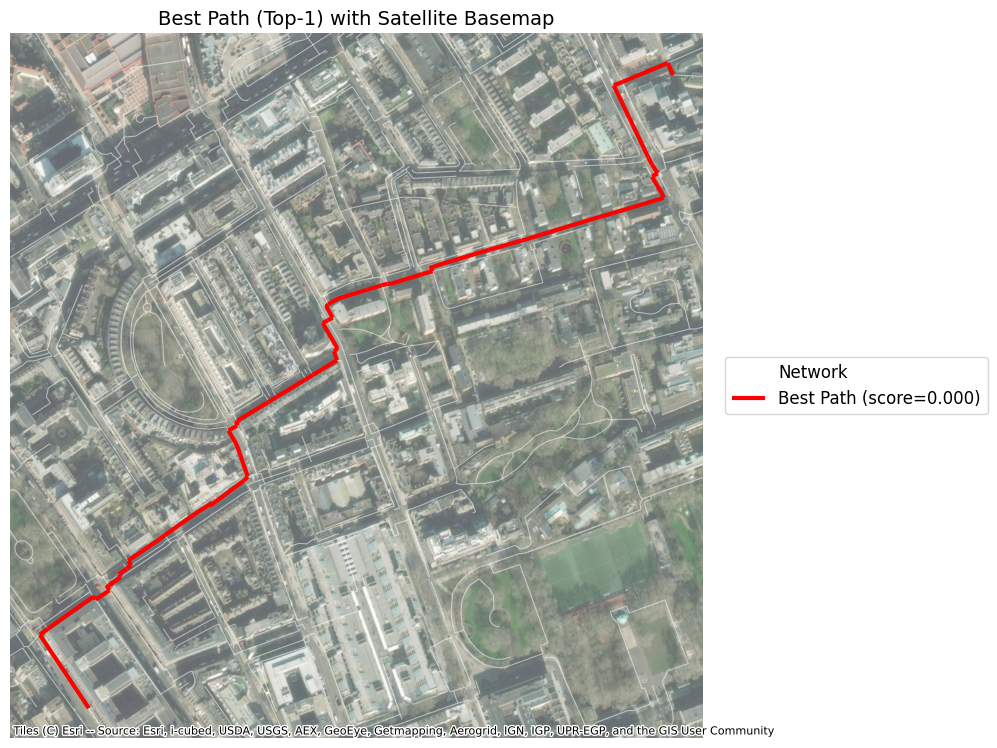

Saved to output/path_results/best_path_iq_ioe_4_walk_length_bea2.png


In [38]:
plot_best_path_satellite(df_result_4_walk_length, G2, output_path="output/path_results/best_path_iq_ioe_4_walk_length_bea2.png")

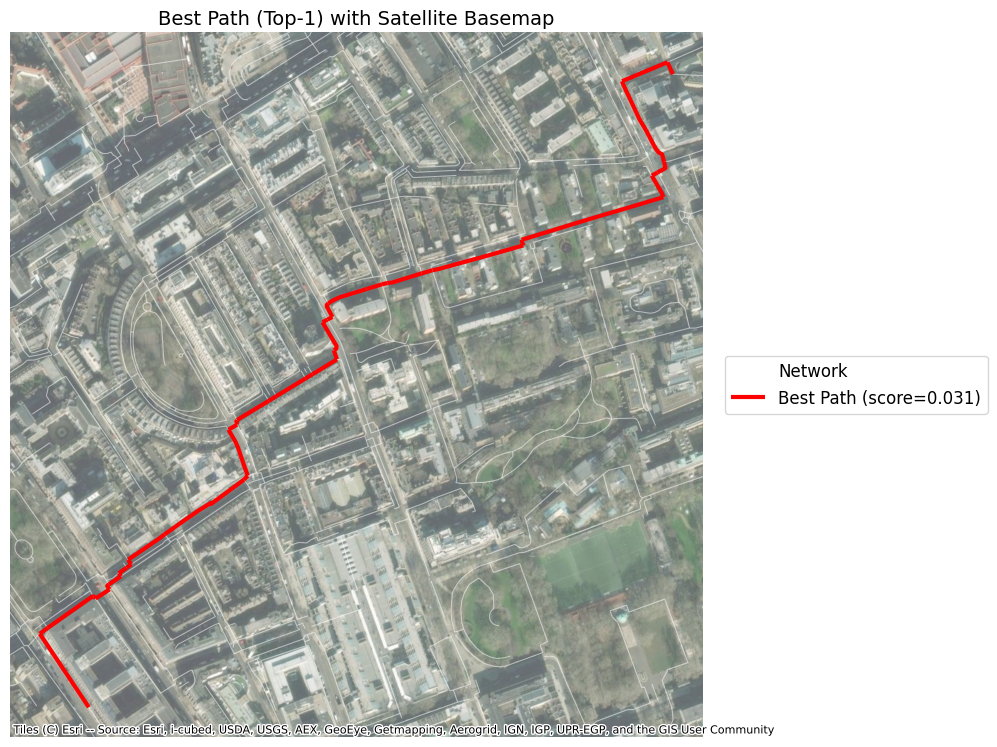

Saved to output/path_results/best_path_iq_ioe_4_walk_green2_bea2.png


In [39]:
plot_best_path_satellite(df_result_4_walk_green2, G2, output_path="output/path_results/best_path_iq_ioe_4_walk_green2_bea2.png")

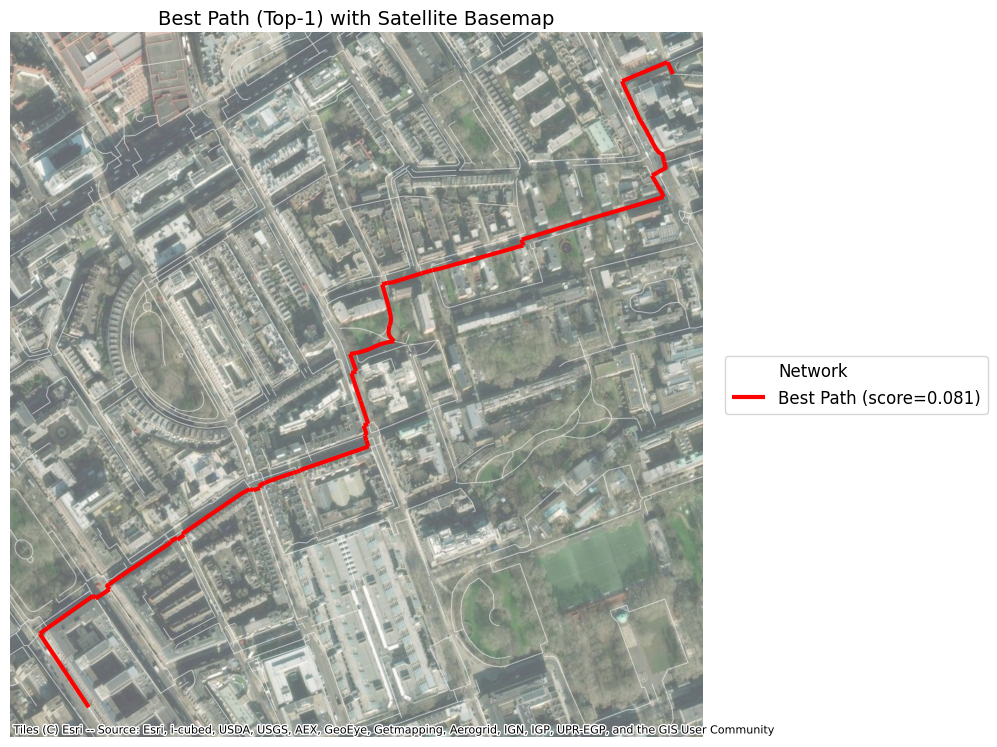

Saved to output/path_results/best_path_iq_ioe_4_walk_half_bea2.png


In [40]:
plot_best_path_satellite(df_result_4_walk_half, G2, output_path="output/path_results/best_path_iq_ioe_4_walk_half_bea2.png")

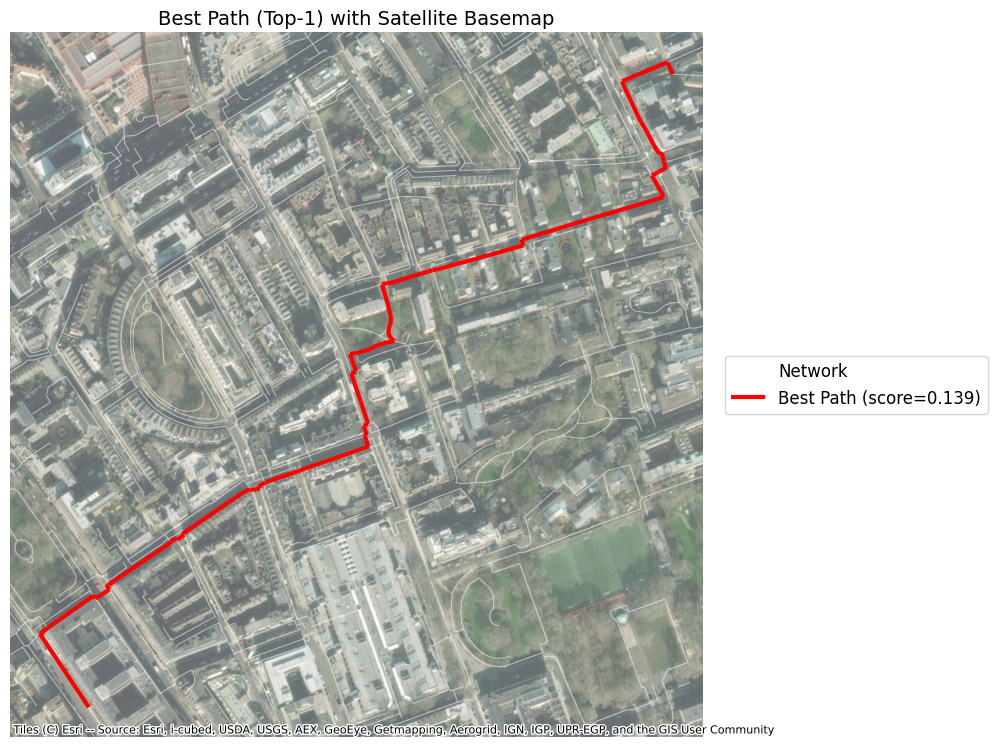

Saved to output/path_results/best_path_iq_ioe_4_walk_green8_bea2.png


In [41]:
plot_best_path_satellite(df_result_4_walk_green8, G2, output_path="output/path_results/best_path_iq_ioe_4_walk_green8_bea2.png")

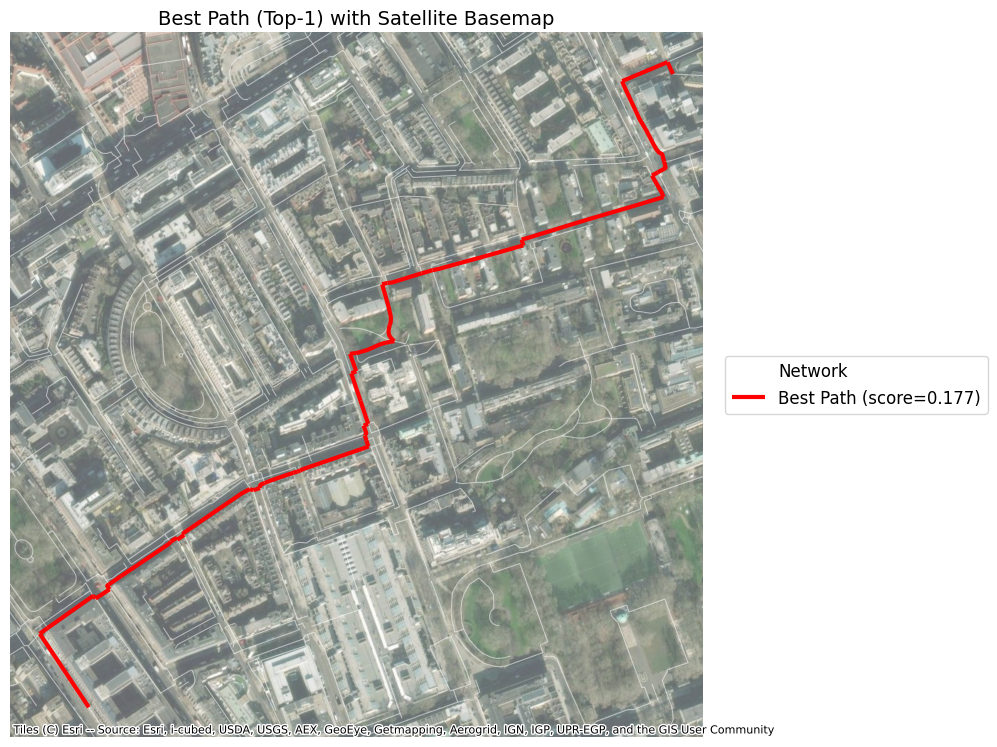

Saved to output/path_results/best_path_iq_ioe_4_walk_green_bea2.png


In [42]:
plot_best_path_satellite(df_result_4_walk_green, G2, output_path="output/path_results/best_path_iq_ioe_4_walk_green_bea2.png")